In [2]:
#
#  Creating a pyomo parest version of example from James Rawlings Reactor Design Book
#  https://github.com/rawlings-group/paresto/blob/master/examples/green_book/hbv_det.m
#

In [1]:
# Import libraries
from pyomo.environ import *
from pyomo.dae import *
import pyomo.contrib.parmest.parmest as parmest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data_df = pd.read_csv('hbv_data.csv')
data_df.head()

,t,ca_exp,cb_exp,cc_exp
0,0.0,0.734562,0.000000,0.000000
1,2.0,0.707371,3.444986,373.654198
2,4.0,0.521003,6.148200,280.451066
3,6.0,0.680192,7.458215,301.503717
4,8.0,0.716159,8.115554,363.551492


In [6]:
data = [{'ca_exp': {k: v for (k, v) in zip(data_df.t, data_df.ca_exp)},
         'cb_exp': {k: v for (k, v) in zip(data_df.t, data_df.cb_exp)},
         'cc_exp': {k: v for (k, v) in zip(data_df.t, data_df.cc_exp)}
        }]

In [13]:
def hbv_model(data):
    
    ca_exp = data['ca_exp']
    cb_exp = data['cb_exp']
    cc_exp = data['cc_exp']
    texp = list(ca_exp.keys())
    
    ca0 = 1.0
    cb0 = 0.0
    cc0 = 0.0
    
    m = ConcreteModel()
    
    m.k1 = Var(initialize = 6.3, bounds = (1e-3, 10))
    m.k2 = Var(initialize = 0.07, bounds = (1e-3, 10))
    m.k3 = Var(initialize = 1412, bounds = (100, 5000))
    m.k4 = Var(initialize = 0.17, bounds = (1e-3, 10))
    m.k5 = Var(initialize = 0.69, bounds = (1e-3, 10))
    m.k6 = Var(initialize = 3.5e-6, bounds = (1e-6, 1e-5))
    
    m.time = ContinuousSet(bounds = (0, max(texp)), initialize = texp)
    
    m.ca = Var(m.time, initialize = ca0)
    m.cb = Var(m.time, initialize = cb0)
    m.cc = Var(m.time, initialize = cc0)
    
    m.dca = DerivativeVar(m.ca)
    m.dcb = DerivativeVar(m.cb)
    m.dcc = DerivativeVar(m.cc)
    
    def _dca_eq(m, t):
        if t == 0:
            return Constraint.Skip
        else:
            return m.dca[t] == m.k2 * m.cb[t] - m.k4 * m.ca[t]
    m.dca_eq = Constraint(m.time, rule = _dca_eq)

    def _dcb_eq(m, t):
        if t == 0:
            return Constraint.Skip
        else:
            return m.dcb[t] == m.k1 * m.ca[t] - m.k2 * m.cb[t] - m.k6 * m.cb[t] * m.cc[t]
    m.dcb_eq = Constraint(m.time, rule = _dcb_eq)
    
    def _dcc_eq(m, t):
        if t == 0:
            return Constraint.Skip
        else:
            return m.dcc[t] == m.k3 * m.ca[t] - m.k5 * m.cc[t] - m.k6 * m.cb[t] * m.cc[t]
    m.dcc_eq = Constraint(m.time, rule = _dcc_eq)

    def _initcon(m):
        yield m.ca[m.time.first()] == ca0
        yield m.cb[m.time.first()] == cb0
        yield m.cc[m.time.first()] == cc0
    m.initcon = ConstraintList(rule = _initcon)
        
    def ComputeFirstStageCost_rule(m):
        return 0
    m.FirstStageCost = Expression(rule=ComputeFirstStageCost_rule)

    def ComputeSecondStageCost_rule(m):
        return sum((m.ca[t] - ca_exp[t]) ** 2 + 
                   1e-2 * (m.cb[t] - cb_exp[t]) ** 2 + 
                   1e-4 * (m.cc[t] - cc_exp[t]) ** 2 
                   for t in texp) 
    m.SecondStageCost = Expression(rule=ComputeSecondStageCost_rule)
   
    def total_cost_rule(model):
        return model.FirstStageCost + model.SecondStageCost
    m.Total_Cost_Objective = Objective(rule=total_cost_rule, sense=minimize)
    
    disc = TransformationFactory('dae.collocation')
    disc.apply_to(m, nfe=60, ncp=4)
    
    #disc = TransformationFactory('dae.finite_difference')
    #disc.apply_to(m, nfe=500, scheme = 'BACKWARD')
    
    return m 

In [14]:
# parameters to be estimated
theta_names = ['k1', 'k2', 'k3', 'k4', 'k5', 'k6']

In [15]:
pest = parmest.Estimator(hbv_model, data, theta_names, tee = True)
obj, theta = pest.theta_est()

Ipopt 3.11.1: max_iter=6000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     8895
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2073

Total number of variables............................:     1455
                     variables with only lower bounds:        0
                variables with lower and upper bou

  74  7.6811213e+04 2.10e+03 1.61e+09  -1.0 2.05e+03  -3.7 6.20e-03 1.24e-01f  1
  75  7.7225911e+04 2.06e+03 1.58e+09  -1.0 6.86e+03  -4.2 4.54e-02 1.73e-02h  1
  76  7.7220688e+04 2.06e+03 1.58e+09  -1.0 2.11e+03  -3.8 2.22e-03 1.26e-03f  1
  77  7.7225436e+04 2.06e+03 1.58e+09  -1.0 3.41e+04    -  8.61e-05 4.49e-05h  1
  78  1.0993398e+05 8.21e+02 7.08e+09  -1.0 3.18e+04    -  2.09e-02 1.48e-01h  1
  79  1.0234646e+05 4.04e+02 4.21e+09  -1.0 2.03e+03  -4.3 6.91e-01 4.68e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.1921876e+05 4.99e+02 4.45e+09  -1.0 4.26e+04    -  7.99e-02 6.95e-02h  1
  81  1.1934041e+05 4.79e+02 3.83e+09  -1.0 7.24e+03  -3.8 5.26e-01 7.78e-02h  4
  82  1.4976300e+05 1.99e+02 1.87e+09  -1.0 3.89e+03  -3.4 2.27e-01 1.00e+00H  1
  83  1.4441020e+05 1.10e+02 3.44e+10  -1.0 7.31e+02  -2.1 1.00e+00 1.00e+00f  1
  84  1.4265149e+05 6.73e+01 2.05e+10  -1.0 3.14e+02  -2.6 1.00e+00 4.21e-01f  1
  85  1.3178806e+05 2.46e+02

 166  1.3157558e+04 9.85e-03 3.05e+03  -1.0 2.00e+00    -  1.00e+00 1.00e+00h  1
 167  1.3157560e+04 1.65e-07 6.33e-02  -1.0 1.05e-02    -  1.00e+00 1.00e+00h  1
 168  1.3157559e+04 3.27e-05 2.05e+01  -2.5 1.59e-01    -  1.00e+00 1.00e+00h  1
 169  1.3157559e+04 4.14e-11 5.12e-07  -2.5 2.96e-05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  1.3157559e+04 2.48e-08 1.56e-02  -3.8 4.38e-03    -  1.00e+00 1.00e+00h  1
 171  1.3157559e+04 3.78e-11 6.74e-07  -3.8 2.25e-08    -  1.00e+00 1.00e+00h  1
 172  1.3157559e+04 7.75e-11 4.92e-05  -5.7 2.43e-04    -  1.00e+00 1.00e+00h  1
 173  1.3157559e+04 3.57e-11 7.79e-07  -5.7 7.13e-11    -  1.00e+00 1.00e+00h  1
 174  1.3157559e+04 2.81e-11 6.35e-07  -8.6 3.01e-06    -  1.00e+00 1.00e+00h  1
 175  1.3157559e+04 2.87e-11 2.31e-06  -8.6 2.09e-11    -  1.00e+00 1.00e+00h  1
 176  1.3157559e+04 2.55e-11 4.07e-07  -8.6 2.43e-11    -  1.00e+00 5.00e-01h  2
 177  1.3157559e+04 2.55e-11

In [16]:
theta

{'k1': 2.0499437714309448,
 'k2': 0.01940662424564609,
 'k3': 192.93788256852437,
 'k4': 0.19027088517691834,
 'k5': 0.3690144565767463,
 'k6': 8.234443443279099e-06}

In [18]:
ms = hbv_model(data[0])
ms.k1.fix(theta['k1'])
ms.k2.fix(theta['k2'])
ms.k3.fix(theta['k3'])
ms.k4.fix(theta['k4'])
ms.k5.fix(theta['k5'])
ms.k6.fix(theta['k6'])

solver = SolverFactory('ipopt')
solver.solve(ms, tee = True)

Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     6963
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      393

Total number of variables............................:     1443
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0


{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 1443, 'Number of variables': 1443, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.11.1\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.10561513900756836}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

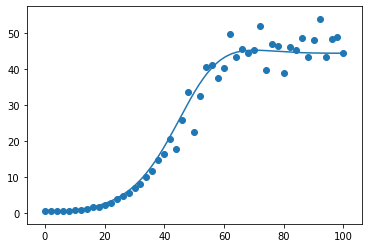

In [20]:
fig, ax = plt.subplots()
ax.plot(list(ms.time), [ms.ca[t]() for t in ms.time])
ax.scatter(data[0]['ca_exp'].keys(), data[0]['ca_exp'].values())

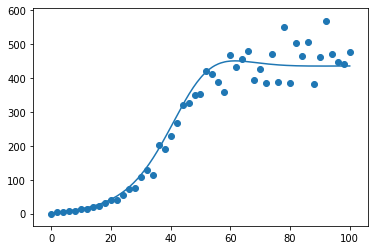

In [21]:
fig, ax = plt.subplots()
ax.plot(list(ms.time), [ms.cb[t]() for t in ms.time])
ax.scatter(data[0]['cb_exp'].keys(), data[0]['cb_exp'].values())

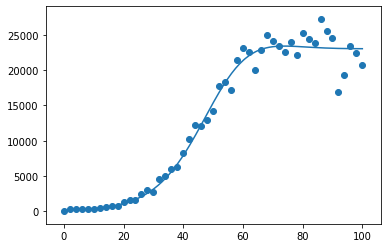

In [22]:
fig, ax = plt.subplots()
ax.plot(list(ms.time), [ms.cc[t]() for t in ms.time])
ax.scatter(data[0]['cc_exp'].keys(), data[0]['cc_exp'].values())